<Axes: >

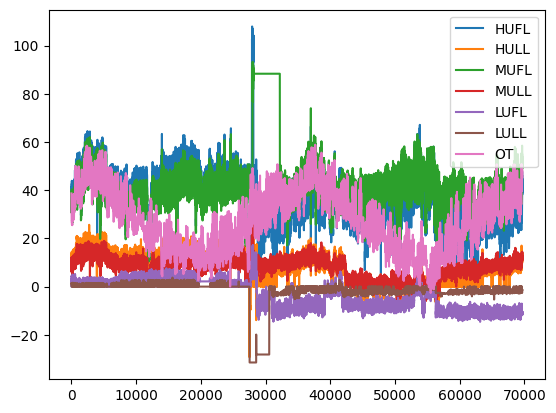

In [1]:
import pandas as pd 

df = pd.read_csv("ETTm2.csv")
df.plot()

In [2]:
df['date'] = pd.to_datetime(df['date'])
training_df = df[df['date'] < df['date'].min() + pd.DateOffset(months=12)]
val_df = df[df['date'] > df['date'].min() + pd.DateOffset(months=12)][df['date'] < df['date'].min() + pd.DateOffset(months=16)]
test_df = df[df['date'] > df['date'].min() + pd.DateOffset(months=16)][df['date'] < df['date'].min() + pd.DateOffset(months=20)]

/tmp/ipykernel_6671/2599488179.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_df = df[df['date'] > df['date'].min() + pd.DateOffset(months=12)][df['date'] < df['date'].min() + pd.DateOffset(months=16)]
/tmp/ipykernel_6671/2599488179.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_df = df[df['date'] > df['date'].min() + pd.DateOffset(months=16)][df['date'] < df['date'].min() + pd.DateOffset(months=20)]


In [3]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self,df, target_column,drop_cols,future_steps, p_lag=0):
        self.df = df.drop(drop_cols, axis=1)
        self.p_lag = p_lag
        self.len_df_minus_lag = len(self.df) - p_lag - future_steps
        self.target_column = target_column
        self.future_steps = future_steps
        
    def __len__(self):
        return self.len_df_minus_lag

    def __getitem__(self, idx):
        input_p_lag = torch.tensor(self.df.iloc[(idx):(idx + self.p_lag),:].astype(float).to_numpy().transpose().reshape(1,-1), requires_grad=True)
        target = torch.tensor(self.df[self.target_column].iloc[(idx + self.p_lag): (idx + self.p_lag + self.future_steps),:].astype(float).to_numpy()).reshape(1,-1)
        return input_p_lag, target

In [14]:
import math
import torch.nn as nn

class DecompositionLayer(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0) 

    def forward(self, x):
        num_of_pads = (self.kernel_size - 1) // 2
        front = x[:, 0:1, :].repeat(1, num_of_pads, 1)
        end = x[:, -1:, :].repeat(1, num_of_pads, 1)
        x_padded = torch.cat([front, x, end], dim=1)

        x_trend = self.avg(x_padded.permute(0, 2, 1)).permute(0, 2, 1)
        x_seasonal = x - x_trend
        return x_seasonal, x_trend

class ARNet(nn.Module):
    def __init__(self, p_lag, n_features, future_steps, decomp_kernel_size = 7):
        super(ARNet, self).__init__()
        self.input_trend_layer = nn.Linear(p_lag * n_features, math.ceil(p_lag * n_features/1.5))
        self.output_trend_layer = nn.Linear(math.ceil(p_lag * n_features/1.5), future_steps)
        self.input_seasonal_layer = nn.Linear(p_lag * n_features, math.ceil(p_lag * n_features/2))
        self.output_seasonal_layer = nn.Linear(math.ceil(p_lag * n_features/2), future_steps)
        self.decomp_layer = DecompositionLayer(decomp_kernel_size)
        self.criterion = nn.MSELoss()

    def forward(self, input):
        input = input.float()
        input_season, input_trend = self.decomp_layer(input)
        x_season = self.input_seasonal_layer(input_season)
        y_hat_season = self.output_seasonal_layer(x_season)
        x_trend = self.input_trend_layer(input_trend)
        y_hat_trend = self.output_trend_layer(x_trend)

        return y_hat_season + y_hat_trend

In [15]:
from torchmetrics.regression import MeanAbsolutePercentageError

def train(epochs, p_lag, future_steps, training_df, validation_df, drop_cols = 'date', target_column = ['OT'], learning_rate=1.e-4, decomp_kernel_size= 7): 
    net = ARNet(p_lag=p_lag, n_features=7, future_steps=future_steps, decomp_kernel_size=decomp_kernel_size)

    train_data = DataLoader(TimeSeriesDataset(training_df, future_steps= future_steps, target_column = target_column,drop_cols=drop_cols,p_lag=p_lag))
    train_loss_list = []
    val_data = DataLoader(TimeSeriesDataset(validation_df,future_steps= future_steps, target_column = target_column,drop_cols=drop_cols,p_lag=p_lag))
    val_loss_list = []

    mae = nn.L1Loss()
    mape = MeanAbsolutePercentageError()

    torch.set_grad_enabled(True)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    running_train_loss = 0.
    running_val_loss = 0.
    
    running_val_mae = 0.
    running_train_mae = 0.

    running_val_mape = 0.
    running_train_mape = 0.

    train_counter = 1
    val_counter = 1
    for epoch in range(epochs): 
        if epoch + 1 != 1: 
            learning_rate = learning_rate / 2
            optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        print(f"Current learning rate is : {learning_rate}")  
        print("---------------------------")
        for i, data in enumerate(train_data):
            inputs, labels = data
            labels = labels.squeeze(0).float()
            optimizer.zero_grad()
            outputs = net(inputs)
            outputs = outputs.squeeze(0)
            loss = net.criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
            optimizer.step()
            running_train_loss += loss.item()

            mae_score = mae(outputs, labels)
            running_train_mae += mae_score.item()
            
            mape_score = mape(outputs, labels)
            running_train_mape += mape_score.item()

            train_counter += 1
            if train_counter % 10000 == 0: 
                print(f"Current (running) training loss at iteration {train_counter} : {running_train_loss/train_counter}")

        train_loss_list.append(running_train_loss/train_counter)
            
        for i, data in enumerate(val_data):
            inputs, test_labels = data
            test_labels = test_labels.squeeze(0).float()
            output = net(inputs)
            output = output.squeeze(0)
            val_loss = net.criterion(output, test_labels)
            mae_score = mae(output, test_labels)
            mape_score = mape(output, test_labels)

            running_val_loss += val_loss.item()
            running_val_mae += mae_score.item()
            running_val_mape += mape_score.item()

            val_counter += 1
        val_loss_list.append(running_val_loss/val_counter)


        if epoch % 1 == 0: 
            print(f"Epoch {epoch}: ")
            print(f"Running (training) MSE is {running_train_loss/train_counter}.")
            print(f"Training MAE is {running_train_mae/train_counter}.")
            print(f"Training MAPE is {running_train_mape/train_counter}.")

            print(f"Test MSE is {running_val_loss/val_counter}.")
            print(f"Test MAE is {running_val_mae/val_counter}.")
            print(f"Test MAPE is {running_val_mape/val_counter}.")
            print("---------------------------")
    
    return net

In [16]:
net = train(epochs = 8, p_lag= 168, future_steps = 24, training_df = training_df, validation_df = val_df, target_column = ['OT'], drop_cols='date', learning_rate=1.e-4 )

test_data = DataLoader(TimeSeriesDataset(val_df,future_steps= 24, target_column = ['OT'],drop_cols='date',p_lag=100))

for i, data in enumerate(test_data):
    inputs, labels = data
    output = net(inputs)
    print(f"predicted output is {output.squeeze(0,1).tolist()} and true value is {labels.squeeze(0,1).tolist()}")
    if i > 1: 
        break

Current learning rate is : 0.0001
---------------------------


Current (running) training loss at iteration 10000 : 1.9135172158539295
Current (running) training loss at iteration 20000 : 1.5470233456742017
Current (running) training loss at iteration 30000 : 1.3137324676938356
Epoch 0: 
Running (training) MSE is 1.2858455710716434.
Training MAE is 0.7811958156702471.
Training MAPE is 321.07866588565867.
Test MSE is 96.00614828507983.
Test MAE is 8.3039207731838.
Test MAPE is 0.22194568783871588.
---------------------------
Current learning rate is : 5e-05
---------------------------
Current (running) training loss at iteration 40000 : 1.34033010277187
Current (running) training loss at iteration 50000 : 1.4552762349001132
Current (running) training loss at iteration 60000 : 1.8517126330329106
Epoch 1: 
Running (training) MSE is 1.9577017951300282.
Training MAE is 0.9272585655435436.
Training MAPE is 306.9585403641023.
Test MSE is 137.94017912313777.
Test MAE is 9.792891522098063.
Test MAPE is 0.26652387429844493.
---------------------------
Curre

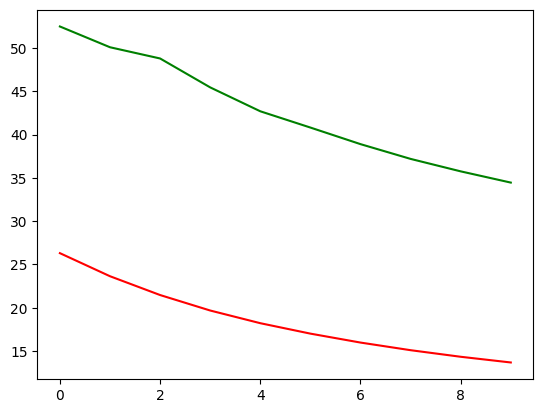

In [ ]:
import matplotlib.pyplot as plt
plt.plot(test_loss_list, 'g', train_loss_list, 'r')
plt.show()